# Assignment 2: Portfolio Optimization
## Arshdeep Singh Bamrah Course: MIE1622

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import matplotlib.pyplot as plt
import ipopt
from scipy import sparse

import cvxpy as cp

C:\Users\arshb\anaconda3\lib\site-packages\ipopt\__init__.py:13: FutureWarning: The module has been renamed to 'cyipopt' from 'ipopt'. Please import using 'import cyipopt' and remove all uses of 'import ipopt' in your code as this will be deprecated in a future release.
  warnings.warn(msg, FutureWarning)


### Rounding procedure for the calculated number of assest

In [2]:
def rounder(x): #parts of the code are from https://stackoverflow.com/questions/53201470/how-to-always-round-up-a-xx-5-in-numpy
    if (x-int(x) >= 0.5): #round the asset up if the secoond decimal place is equal or greater that 0.5
        return np.ceil(x)
    else: 
        return np.floor(x) #round the asset down otherwise
rounder_vec = np.vectorize(rounder) #vectorize to apply the function to every value in array

### Buy and hold portfolio

In [3]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices, curr_borrow):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal, curr_borrow

### Equally Weighted portfolio

In [4]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices, curr_borrow):
    #compute current portfolio value
    V_cur = np.dot(cur_prices, x_init) 
    w = 1/len(x_init) #weights to be equal amoung all assets for equally weighted strategy
    x_optimal, cash_optimal = rebalance(cur_prices, x_init, w, cash_init) #applying rebalancing algorithim to balance and 
                                                                          #optimize the number of stocks and cash account balance.
    return x_optimal, cash_optimal, curr_borrow

### Minimum variance portfolio

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & w^TQw \\
{\rm s.t.} & \sum_i w_i = 1\\
& w \geq 0
\end{array}
\end{equation}

In [5]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices, curr_borrow):
    np.random.seed(978351)
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize) #setting cplex to minimize
    n = len(x_init)
    c  = [0.0] * n #no linear part in the equation
    lb = [0.0] * n # w>= 0
    ub = [1.0] * n #upper bound = 1
    
    A = [] #LHS of the constraints 
    for k in range(n):
        A.append([[0, 1],[1.0, 0]])
    
    var_names = ["w_%s" % i for i in range(1,n+1)] #total number of variables
    
    cpx.linear_constraints.add(rhs=[1.0, 0], senses="EG") #RHS of the constraints
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names) #adding the linear part of the equation into the solver
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] #defining the quadratic part of the equations
    
    
    cpx.objective.set_quadratic(Qmat) #adding the quadratic part of the solver
    
    cpx.parameters.threads.set(4)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    # Compute min varuabce solution with CPLEX
    cpx.solve()
    w_cur = cpx.solution.get_values()
      
    x_optimal, cash_optimal = rebalance(cur_prices, x_init, w_cur, cash_init)#applying rebalancing algorithim to balance and 
                                                                          #optimize the number of stocks and cash account balance.
    
    return x_optimal, cash_optimal, curr_borrow

### Maximum Sharpe Ratio portfolio

\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{y,k} & y^T Q y \\
  \mbox{s.t.} & \sum_{i=1}^n (mu_i - r_f)y_i = 1 \\
  & \sum_{i=1}^n y_i = K \\
  & l \cdot k \leq Ay \leq u \cdot k \\
  & k \geq 0
 \end{array}
\end{equation}

In [6]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, curr_borrow):
    np.random.seed(978351)
    
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize) #setting cplex to minimize
    n = len(x_init)
    c  = [0.0] * 21 #no linear part on the equation
    lb = [0.0] * 21 # k>= 0
    ub = [math.inf] * 21 #upper bound = infinity
    
    #LHS of the constraints 
    Atilde = []
 
    for k in range(n):
        Atilde.append([[0, 1, 2+k],[(mu[k]-(r_rf/252)), 1.0, 1.0]])
    Atilde.append([[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21],[0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]])
    #adding additonal column for calculating kappa
    
    #RHS of the constraints
    u_tilde = []
    u_tilde = [0.0] * (n+2)
    u_tilde[0] = 1.0 # sum((mu_i-rf)*y) = 1.0
    u_tilde[1] = 0.0 # sum(y_i) = k

    #Setting up the conditions for each constraints
    my_sense    = "EE" + "L" * n
    
    var_names = ["y_%s" % i for i in range(1, n+2)] #total number of variables additonal 1 due to kappa
    
 
    cpx.linear_constraints.add(rhs=u_tilde, senses=my_sense) #RHS of the constraints
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=Atilde, names=var_names) #adding the linear part of the equation into the solver
    
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] #defining the quadratic part of the equations
    
    for k in range(n): #additonal addtional row and column for kappa
        Qmat.append([[0],[0.0]])
        
    cpx.objective.set_quadratic(Qmat) #adding the quadratic part of the solver
    
    cpx.parameters.threads.set(4)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    # Compute max sharpe ratio solution with CPLEX
    cpx.solve()
    
    
    if cpx.solution.get_status_string()== 'infeasible':
            
            x_optimal = x_init
            cash_optimal = cash_init
    else:
        y = cpx.solution.get_values()
        kapa = y[-1] #kapa is the last element of the solution as per the equation setup
        yl = y[:-1] #first 20 elements are the solution for y
        yl = np.asarray(yl)

        w_new = yl/kapa #w = y/kappa as per lecture slides

        x_optimal, cash_optimal = rebalance(cur_prices, x_init, w_new, cash_init)#applying rebalancing algorithim to balance and 
                                                                              #optimize the number of stocks and cash account balance.
    
        
    curr_borrow = 0
    
    
    return x_optimal, cash_optimal, curr_borrow


### Buy and hold with Equally Weighted portfolio (additional strategy as per part 3 of the assignment 1)

In [7]:
def strat_buy_and_hold_equally_weighted(x_init, cash_init, mu, Q, cur_prices, curr_borrow):
    V_cur = np.dot(cur_prices, x_init) #calculating current value
    W_new = np.asarray(1/len(x_init))  #equally weighted assets
    
    #calculate number of stocks to buy and sell
    new_x = np.divide(np.multiply(V_cur,W_new), cur_prices)
    new_x = rounder_vec(new_x) #applying rounding 
    
    x_optimal = new_x #equally weighted stocks
    cash_optimal = cash_init #no change in cash account as per the assignment
    
    return x_optimal, cash_optimal, curr_borrow

### Equal Risk Contributions

\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{w} & \displaystyle \sum_{i=1}^n \sum_{j=1}^n \left( w_i (Qw)_i - w_j (Qw)_j \right)^2 \\
  \mbox{s.t.} & \sum_{i=1}^n w_i = 1 \\
  & w \geq 0
 \end{array}
\end{equation}

In [8]:
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        n = len(x)
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        a = np.dot(Q,x)
        b = np.multiply(a, x)
        c = sum(-1*b)
        grad = np.zeros(len(x))
        
        for  i in range(0, len(x)):
            grad[i] = 2*a[i]*(c+len(x)*b[i])
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * len(x)
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * len(x)])

In [9]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices, curr_borrow):
    np.random.seed(492305)
    n = len(x_init) 
    w0 = [1.0/n] * n
    # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization

    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    # Compute variance and asset risk contributions for the ERC portfolio
    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
    
  
    if np.allclose(np.sum(w_erc),1) and np.allclose(np.sum(RC_ERC), std_ERC): #check to see if equal variaence and sum of weights
        x_optimal, cash_optimal = rebalance(cur_prices, x_init, w_erc, cash_init)#applying rebalancing algorithim to balance and 
                                                                          #optimize the number of stocks and cash account balance.
    
    return x_optimal, cash_optimal, curr_borrow

### Leveraged Equal Risk Contribution

In [10]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices, curr_borrow):
    np.random.seed(492305)
    n = len(x_init) 
    w0 = [1.0/n] * n
    # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization

    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
    
    # Compute variance and asset risk contributions for the ERC portfolio
    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
    
    if np.allclose(np.sum(w_erc),1) and np.allclose(np.sum(RC_ERC), std_ERC):
        x_optimal, cash_optimal, borrow = leveragedrebalance(cur_prices, x_init, w_erc, cash_init, curr_borrow)#applying rebalancing algorithim to balance and 
                                                                          #optimize the number of stocks and cash account balance.
    
    
    return x_optimal, cash_optimal, borrow

### Robust mean-variance optimization

\begin{equation}
  \begin{array}{lll}
    \min   & w^TQw       \\
    {\rm s.t.} & \begin{array}[t]{@{\hspace{0cm}}r@{\hspace{0.1cm}}c@{\hspace{0.1cm}}ll}
          \sum_{i=1}^n w_i & = & 1  \\
          \mu^T w & \geq & \varepsilon_{\rm ret} \\
          w^T \Theta w & \leq & \tilde{\varepsilon}_{\rm rob} \\
            w & \geq & 0
     \end{array}
  \end{array}
\end{equation}

In [11]:
def printtargets(mu, Q, x, todayprice, period, strategy):
    
    # Target portfolio return estimation error
    V_cur = np.dot(todayprice, x)
    w = np.divide(np.multiply(todayprice, x), V_cur)

    var_matr = np.diag(np.diag(Q)) # Required portfolio robustness
    rob_bnd1 = np.dot(w, np.dot(var_matr, w))

    # Target portfolio return 
    Portf_Retn1 = np.dot(mu, w)
    
    return rob_bnd1, Portf_Retn1

In [12]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices, curr_borrow):
    
    n = len(x_init)
    w0 = [1/n]*n
    var_matr = np.diag(np.diag(Q))
    rob_init = np.dot(w0, np.dot(var_matr, w0))
    rob_bnd = rob_init #target variance to equal to equally weighted 
    
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    daily_rf = r_rf/252
    
    Portf_Retn = daily_rf #target portfolio return to equal daily  risk free rate of return
        
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n    
    
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    
    var_names = ["w_%s" % i for i in range(1,n+1)]
    
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    
    cpx.objective.set_quadratic(Qmat)
    
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    if cpx.solution.get_status_string()== 'infeasible': #if no cplex solution, keep the portfolio same as the last period
            
            x_optimal = x_init
            cash_optimal = cash_init
    else:
        
        w_rMV = np.array(cpx.solution.get_values()) 
        w_rMV[w_rMV<1e-7] = 0 #zeroing the weights which are closer to zero
        w_rMV = w_rMV / np.sum(w_rMV) #reassigining the weights
       
        x_optimal, cash_optimal = rebalance(cur_prices, x_init, w_rMV, cash_init)#applying rebalancing algorithim to balance and 
                                                                          #optimize the number of stocks and cash account balance.
    borrow = 0
    
    return x_optimal, cash_optimal, borrow

### Reading the Data

In [13]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

In [14]:
# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [15]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [16]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])

In [17]:
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [18]:
Q.shape

(20, 20)

In [19]:
# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [20]:
# Initial positions in the portfolio

init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

In [21]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 1000013.0



In [22]:
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

In [23]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

In [24]:
# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

In [25]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 7  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

### Rebalancing Algorithm

In [26]:
#rebalance
def rebalance(todayprice, old_x, W_new, Cash_old):
    Cash=False
    
    #compute current portfolio value
    V_cur = np.dot(todayprice, old_x)
    W_new = np.asarray(W_new)
    #calculate number of stocks to buy and sell
    new_x = np.divide(np.multiply(V_cur,W_new), todayprice)
    new_x = rounder_vec(new_x) #round up or down up when first decimal is 0.5 or above and round down otherwise
    
 
    #rebalancing loop
    while Cash==False:
        #calculate buy or sell
        change_x = np.subtract(new_x, old_x) #if positive means buy if negative means sell
        tran_buyl = []
        tran_selll = []
        for i in change_x:
            if i>=0: #making a list of all the stocks which are to buy
                tran_buyl.append(1)
                tran_selll.append(0)
            if i<0: #making a list of all the stocks which are to sell
                tran_buyl.append(0)
                tran_selll.append(1)
        tran_buyl =  np.asarray(tran_buyl) #list with value 1 are to buy stocks
        tran_selll =  np.asarray(tran_selll) #list with value 1 are to sell stocks
        
        tran_buy = np.sum(new_x * tran_buyl * todayprice) * 0.005 #total transaction cost for buy the stocks
        tran_sell = np.sum(new_x * tran_selll * todayprice) * 0.005 #total transaction cost for sell the stocks
        
        Newvalue = np.dot(new_x, todayprice) + tran_buy - tran_sell #total value of the portfolio adding buying cost and subtracting sell cost
              
        Cash_new = V_cur - Newvalue + Cash_old #balancing equation (current portfolio value - new portfolio value + cash account)
        
        #balacing the cash account so its never below zero
        
        if Cash_new >= 0: #if cash account positive then break the rebalancing loop and return the cash and x optimal
            Cash == True
            break
         
        if Cash_new < 0: #if cash negative then recalculate x optimal
            newlist = (np.multiply(new_x, todayprice) - abs(Cash_new)).tolist() #which stock has a value more than the cash account
            idx_list = np.array(newlist).argsort().tolist() #listing the stocks index in a ascending order
            
            for i in idx_list: #checking the stock value by lowest to highest
                if newlist[i] > 0: #if the stock value is above zero and very close to cash account balance then remove that stock
                    new_x[i] = new_x[i] - 1 #removing the stock which has a close value to the abs(negative cash value). Minimizing the impact on the overall portfolio
                    break
                                                
    return new_x, Cash_new


### Leveraged Equal Risk Contribution Rebalance Algorthim 

In [27]:
#rebalance
def leveragedrebalance(todayprice, old_x, W_new, Cash_old, borw_amt):
    #amount to return
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    bimonthly_rf = (1+r_rf)**(1/6) - 1
    amt_return = borw_amt*(1+ bimonthly_rf)
    sell_x = np.zeros(len(old_x))
    if amt_return > 0:
        
        carry = False
        sell_x = old_x/2
        sell_x = rounder_vec(sell_x)

        while carry == False:
            amt_aval_to_ret = np.dot(todayprice, sell_x) - np.sum(sell_x * todayprice) * 0.005 #total transaction cost for sell the stocks
            differ_lev = amt_aval_to_ret - amt_return #differnve between value(after selling half of the portfolio) and leveaged amount    
           
            if differ_lev >= 0: #if cash account positive then break the rebalancing loop and return the cash and x optimal
                    carry == True
                    Cash_old = Cash_old + differ_lev
                    amt_return = 0
                    break

            if differ_lev < 0: #if cash negative then recalculate x optimal
                newlist_lev = (np.multiply(old_x, todayprice) - abs(differ_lev)).tolist() #which stock has a value more than the cash account
                idx_list_lev = np.array(newlist_lev).argsort().tolist() #listing the stocks index in a ascending order
                
                for i in idx_list_lev: #checking the stock value by lowest to highest
                    #if newlist_lev[i] > 0: #if the stock value is above zero and very close to cash account balance then add that stock
                     if old_x[i] > 0:
                        sell_x[i] = sell_x[i] + 10 #add the stock which has a close value to the abs(differ_lev). Minimizing the impact on the overall portfolio
                        break
    
    ### Code below is same as rebalance algorithim shown above
        
    if amt_return == 0:
        
        Cash=False

        #compute current portfolio value
        old_x = old_x - sell_x
        #old_x = rounder_vec(old_x)
        V_cur = np.dot(todayprice, old_x) + Cash_old
        W_new = np.asarray(W_new)   
        #calculate number of stocks to buy and sell
        new_x = np.divide(np.multiply(V_cur,W_new), todayprice)
        new_x = 2*new_x
        new_x = rounder_vec(new_x) #round up or down up when first decimal is 0.5 or above and round down otherwise
        V_cur = np.dot(todayprice, new_x)
        borw_amt = V_cur/2
        
        #rebalancing loop
        while Cash==False:
            #calculate buy or sell
            change_x = np.subtract(new_x, old_x) #if positive means buy if negative means sell
            tran_buyl = []
            tran_selll = []
            for i in change_x:
                if i>=0: #making a list of all the stocks which are to buy
                    tran_buyl.append(1)
                    tran_selll.append(0)
                if i<0: #making a list of all the stocks which are to sell
                    tran_buyl.append(0)
                    tran_selll.append(1)
            tran_buyl =  np.asarray(tran_buyl) #list with value 1 are to buy stocks
            tran_selll =  np.asarray(tran_selll) #list with value 1 are to sell stocks

            tran_buy = np.sum(new_x * tran_buyl * todayprice) * 0.005 #total transaction cost for buy the stocks
            tran_sell = np.sum(new_x * tran_selll * todayprice) * 0.005 #total transaction cost for sell the stocks

            Newvalue = np.dot(new_x, todayprice) + tran_buy - tran_sell #total value of the portfolio adding buying cost and subtracting sell cost

            Cash_new = V_cur - Newvalue  #balancing equation (current portfolio value - new portfolio value + cash account)

            #balacing the cash account so its never below zero

            if Cash_new >= 0: #if cash account positive then break the rebalancing loop and return the cash and x optimal
                Cash == True
                break

            if Cash_new < 0: #if cash negative then recalculate x optimal
                newlist = (np.multiply(new_x, todayprice) - abs(Cash_new)).tolist() #which stock has a value more than the cash account
                idx_list = np.array(newlist).argsort().tolist() #listing the stocks index in a ascending order

                for i in idx_list: #checking the stock value by lowest to highest
                    if newlist[i] > 0: #if the stock value is above zero and very close to cash account balance then remove that stock
                        new_x[i] = new_x[i] - 1 #removing the stock which has a close value to the abs(negative cash value). Minimizing the impact on the overall portfolio
                        break
                                                
    return new_x, Cash_new, borw_amt

### Portfolio Calculation main function

In [28]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
rob_bnd = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
Portf_Retn = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
borrow = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
startdate = []
enddate = []
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 20:
        cur_year  = 20 + math.floor(period/7)
    else:
        cur_year  = 2020 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    
    startdate.append(day_ind_start)
    enddate.append(day_ind_end)
    

   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:] 

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            curr_borrow = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
            curr_borrow = borrow[strategy, period-2]

      # Compute strategy
        x[strategy, period-1], cash[strategy, period-1], borrow[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, curr_borrow)
       
      #Verify that strategy is feasible (you have enough budget to re-balance portfolio): See function rebalance
      #Check that cash account is >= 0: See function rebalance
      #Check that we can buy new portfolio subject to transaction costs: See function rebalance

        #print(' "{0}" Cash Account Balance = $ {1:.2f}'.format(strategy_names[strategy], cash[strategy, period-1]))  
      # Compute portfolio value

        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        begin_value = portf_value[strategy][day_ind_start][0]-borrow[strategy, period-1]
        value_end = portf_value[strategy][day_ind_end][0]-(borrow[strategy, period-1]*((1+0.025)**(1/6)))
        print('Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             begin_value, value_end))
        rob_bnd[strategy, period-1], Portf_Retn[strategy, period-1] = printtargets(mu, Q, curr_positions, cur_prices, period, strategy)
      
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2020, end date 02/28/2020
Strategy "Buy and Hold", value begin = $ 1000013.00, value end = $ 893956.82
Strategy "Equally Weighted Portfolio", value begin = $ 995541.54, value end = $ 896758.01
Strategy "Mininum Variance Portfolio", value begin = $ 997733.02, value end = $ 920765.02
Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 995037.92, value end = $ 926806.80
Strategy "Equal Risk Contributions Portfolio", value begin = $ 996145.88, value end = $ 902951.42
Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 992161.51, value end = $ 801588.93
Strategy "Robust Optimization Portfolio", value begin = $ 997169.28, value end = $ 922436.41

Period 2: start date 03/02/2020, end date 04/30/2020
Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
Strategy "Equally Weighted Portfolio", value begin = $ 935609.12, value end = $ 866799.13
Strategy "Mininum Variance Portfolio", value begin = $ 962078.97, value end 

Strategy "Equal Risk Contributions Portfolio", value begin = $ 1478391.41, value end = $ 1531257.93
Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1675166.08, value end = $ 1786617.73
Strategy "Robust Optimization Portfolio", value begin = $ 1384063.94, value end = $ 1414798.34


In [29]:
df_rob_bnd = pd.DataFrame(rob_bnd.transpose(), columns = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr','strat_robust_optim'])

In [30]:
df_Portf_Retn = pd.DataFrame(Portf_Retn.transpose(), columns = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim'])

In [31]:
df_rob_bnd.astype('float64').describe()

,strat_buy_and_hold,strat_equally_weighted,strat_min_variance,strat_max_Sharpe,strat_equal_risk_contr,strat_lever_equal_risk_contr,strat_robust_optim
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,0.000145,0.000036,0.000096,0.000459,0.000033,0.000033,0.000052
std,0.000226,0.000041,0.000137,0.001225,0.000039,0.000039,0.000064
min,0.000021,0.000013,0.000024,0.000041,0.000012,0.000012,0.000014
25%,0.000048,0.000017,0.000035,0.000054,0.000015,0.000015,0.000029
50%,0.000065,0.000024,0.000044,0.000094,0.000021,0.000021,0.000035
75%,0.000124,0.000034,0.000089,0.000170,0.000033,0.000032,0.000041
max,0.000845,0.000162,0.000514,0.004344,0.000153,0.000154,0.000250


In [32]:
df_Portf_Retn.astype('float64').describe()

,strat_buy_and_hold,strat_equally_weighted,strat_min_variance,strat_max_Sharpe,strat_equal_risk_contr,strat_lever_equal_risk_contr,strat_robust_optim
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,-0.000119,0.001362,0.000358,0.001905,0.001172,0.001171,0.000870
std,0.001327,0.001998,0.001573,0.002487,0.001988,0.001991,0.001624
min,-0.002805,-0.002338,-0.001833,-0.001572,-0.002235,-0.002236,-0.001774
25%,-0.000659,0.000326,-0.000667,0.000233,0.000198,0.000193,-0.000061
50%,-0.000428,0.001183,0.000101,0.001841,0.000922,0.000935,0.000595
75%,0.000574,0.002582,0.001169,0.003523,0.002461,0.002466,0.002367
max,0.002278,0.004464,0.003445,0.006966,0.004232,0.004243,0.003385


### Plotting Results

In [33]:
# Plot results
###################### Insert your code here ############################

### Daily value each strategy

In [34]:
periods = [0,1,2,3,4,5,6,7,8,9,10,11]


In [35]:
#function to calculate the daily value of the portfolio given the strategy 
def daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=0):
    g = np.array([])
    da = np.array([])
    for s,e,p,c in zip(startdate, enddate, periods, cash[strategy]):
        d = np.dot(data_prices[s:e], x[strategy][p]) + c - borrow[strategy][p]
        g = np.hstack((g,d))
        da = np.hstack((da,dates[s:e]))
    return(da, g)

In [36]:
#daily value each strategy
Dates1, Buy_hold = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=0)
Dates1, Eq_weight = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=1)
Dates1, Min_var = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=2)
Dates1, Max_sharpe = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=3)
Dates1, Equal_risk_contr = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=4)
Dates1, Lever_equal_risk_contr = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=5)
Dates1, Robust_optim = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=6)

In [37]:
#creating a dataframe contatining the daily portfolio value for each strategy 

da_valuedf = pd.DataFrame(index = Dates1) 
da_valuedf['Buy_hold'] = Buy_hold
da_valuedf['Eq_weight'] = Eq_weight
da_valuedf['Min_var'] = Min_var
da_valuedf['Max_sharpe'] = Max_sharpe
da_valuedf['Equal_risk_contr'] = Equal_risk_contr
da_valuedf['Lever_equal_risk_contr'] = Lever_equal_risk_contr
da_valuedf['Robust_optim'] = Robust_optim

In [38]:
da_valuedf

,Buy_hold,Eq_weight,Min_var,Max_sharpe,Equal_risk_contr,Lever_equal_risk_contr,Robust_optim
01/02/2020,1.000013e+06,9.955415e+05,9.977330e+05,9.950379e+05,9.961459e+05,9.921615e+05,9.971693e+05
01/03/2020,9.890027e+05,9.826210e+05,9.863916e+05,9.821267e+05,9.840893e+05,9.680638e+05,9.863584e+05
01/06/2020,9.871785e+05,9.859736e+05,9.907733e+05,9.897200e+05,9.883982e+05,9.766846e+05,9.908226e+05
01/07/2020,9.760963e+05,9.838297e+05,9.900860e+05,9.926997e+05,9.867302e+05,9.733428e+05,9.885778e+05
01/08/2020,9.782857e+05,9.893087e+05,9.966080e+05,1.002072e+06,9.922950e+05,9.844915e+05,9.949296e+05
...,...,...,...,...,...,...,...
12/23/2021,9.436135e+05,1.644684e+06,1.074375e+06,2.296341e+06,1.527342e+06,1.784536e+06,1.415138e+06
12/27/2021,9.437578e+05,1.669496e+06,1.080884e+06,2.346017e+06,1.548333e+06,1.832407e+06,1.429531e+06
12/28/2021,9.452071e+05,1.667451e+06,1.084371e+06,2.342550e+06,1.547876e+06,1.831441e+06,1.431105e+06
12/29/2021,9.391084e+05,1.660650e+06,1.078445e+06,2.333705e+06,1.541963e+06,1.817911e+06,1.425405e+06


Text(0, 0.5, 'Value $ (In Millions)')

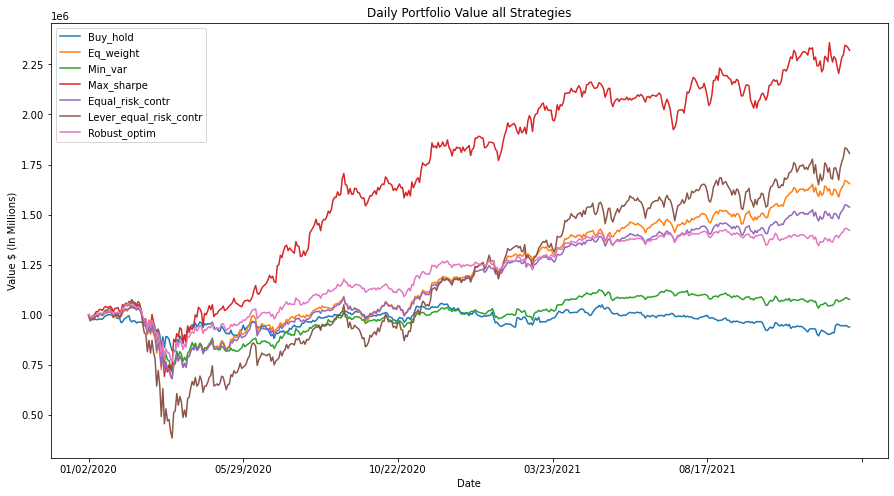

In [39]:
#Showing all strategies in one chart 
da_valuedf.plot.line(figsize = (15,8))
plt.title('Daily Portfolio Value all Strategies')
plt.xlabel('Date')
plt.ylabel('Value $ (In Millions)')

In [40]:
# #daily Value Maximum Sharpe Ratio strategy
# fig, ax = plt.subplots(figsize = (20,8))
# da_valuedf['Max_sharpe'].plot.line()
# plt.title('Daily Portfolio Value Maximum Sharpe Ratio')
# plt.xlabel('Date')
# plt.ylabel('Value $ (In Millions)')

### Maximum Drawdown

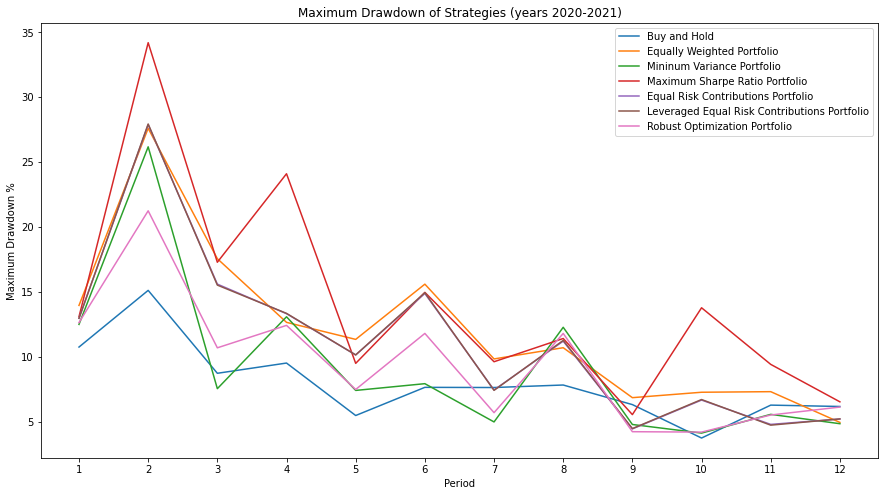

In [41]:
#maximum drawdown
fig = plt.figure(figsize=(15,8))
for strategy in range(N_strat):
    max_dd_list = []
    for period in range(1, N_periods+1):
        if dates_array[0, 0] == 20:
            cur_year  = 20 + math.floor(period/7)
        else:
            cur_year  = 2020 + math.floor(period/7)

        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        maxdrawdown = abs(portf_value[strategy][day_ind_start:day_ind_end+1].max()-portf_value[strategy][day_ind_start:day_ind_end+1].min())/portf_value[strategy][day_ind_start:day_ind_end+1].max()*100
        max_dd_list.append(maxdrawdown)
    plt.plot(range(1,13),max_dd_list,label=strategy_names[strategy])
plt.xlabel('Period')
plt.ylabel('Maximum Drawdown %')
plt.title('Maximum Drawdown of Strategies (years 2020-2021)')
plt.xticks(np.arange(1,13))
plt.yticks()
plt.legend()
plt.show()

### Dynamic Portfolio Change

In [42]:
#Function to calculate the dynamic weight change based on the daily value of each strategy
def dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=0):
    g = np.empty(shape=[0, 20])
    da = np.array([])
    for s,e,p,c in zip(startdate, enddate, periods, cash[strategy]): 
        j = np.dot(data_prices[s:e], x[strategy][p]) + c
        d = np.divide((np.multiply(data_prices[s:e], x[strategy][p])), j.reshape(-1,1))
        g = np.vstack((g,d))
        da = np.hstack((da,dates[s:e]))
    return(da, g)

In [43]:
#calculating dynamic change in the weights for Min variance and Max Sharpe ratio strategies
Dates1, Min_var_weights = dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=2)
Dates1, Max_sharpe_weight = dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=3)
Dates1, Equal_risk_contr_weight = dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=4)
Dates1, Lever_equal_risk_weight = dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=5)
Dates1, Robust_optim_weight = dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=6)

In [44]:
da_valuedf3 = pd.DataFrame(Min_var_weights, columns = list(df.columns)[1:], index = Dates1)
da_valuedf4 = pd.DataFrame(Max_sharpe_weight, columns = list(df.columns)[1:], index = Dates1)
da_valuedf5 = pd.DataFrame(Equal_risk_contr_weight, columns = list(df.columns)[1:], index = Dates1)
da_valuedf6 = pd.DataFrame(Lever_equal_risk_weight, columns = list(df.columns)[1:], index = Dates1)
da_valuedf7 = pd.DataFrame(Robust_optim_weight, columns = list(df.columns)[1:], index = Dates1)

Text(0, 0.5, 'Asset Weights')

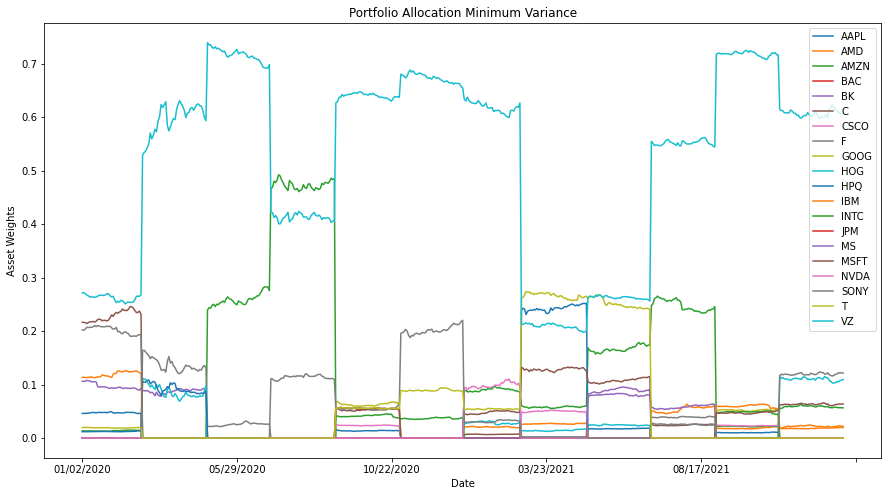

In [45]:
#ploting the chart showing Portfolio Allocation for Minimum variance Strategy
da_valuedf3.plot.line(figsize = (15,8))
plt.title('Portfolio Allocation Minimum Variance')
plt.xlabel('Date')
plt.ylabel('Asset Weights')

In [46]:
# axes = da_valuedf3.plot.line(subplots=True,figsize = (20,50))
# axes[0].set_title('Portfolio Allocation Minimum Variance')
# axes[19].set_xlabel('Date')
# for i in range(0,20):
#     axes[i].set_ylabel('Asset Weight')

Text(0, 0.5, 'Asset Weights')

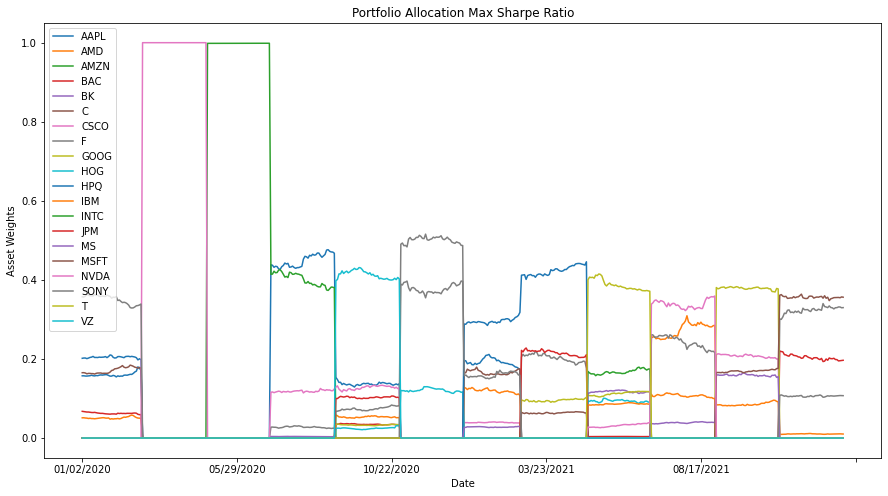

In [47]:
#ploting the chart showing Portfolio Allocation for Max Sharpe Ratio Strategy
da_valuedf4.plot.line(figsize = (15,8))
plt.title('Portfolio Allocation Max Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Asset Weights')

In [48]:
# axes = da_valuedf4.plot.line(subplots=True,figsize = (20,50))
# axes[0].set_title('Portfolio Allocation Max Sharpe Ratio')
# axes[19].set_xlabel('Date')
# for i in range(0,20):
#     axes[i].set_ylabel('Asset Weight')

Text(0, 0.5, 'Asset Weights')

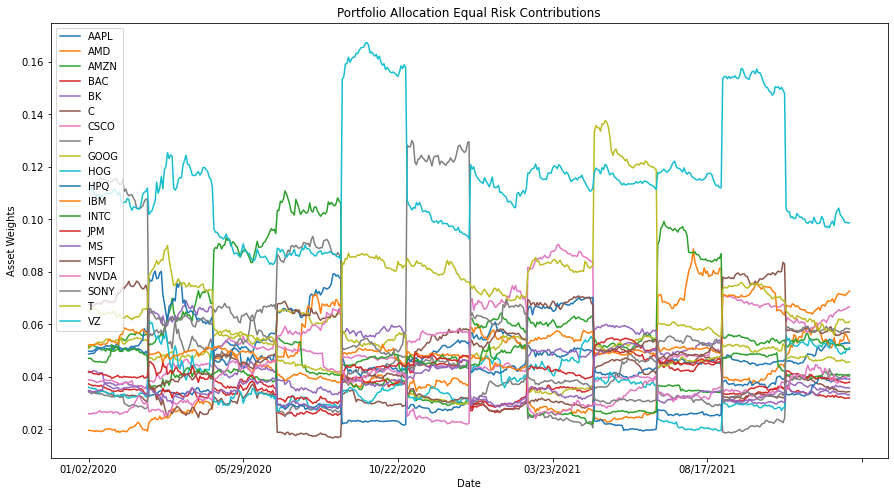

In [49]:
#ploting the chart showing Portfolio Allocation for Equal Risk Contributions Strategy
da_valuedf5.plot.line(figsize = (15,8))
plt.title('Portfolio Allocation Equal Risk Contributions')
plt.xlabel('Date')
plt.ylabel('Asset Weights')

Text(0, 0.5, 'Asset Weights')

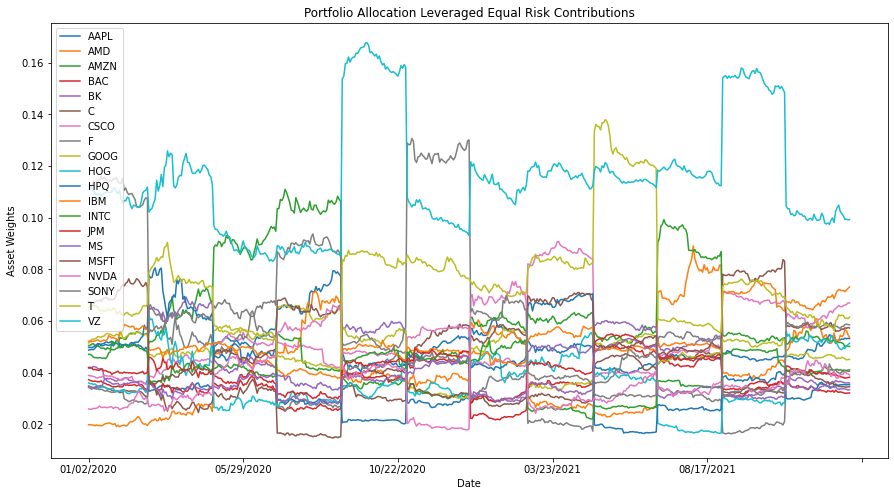

In [50]:
#ploting the chart showing Portfolio Allocation for Leveraged Equal Risk Contributions Strategy
da_valuedf6.plot.line(figsize = (15,8))
plt.title('Portfolio Allocation Leveraged Equal Risk Contributions')
plt.xlabel('Date')
plt.ylabel('Asset Weights')

Text(0, 0.5, 'Asset Weights')

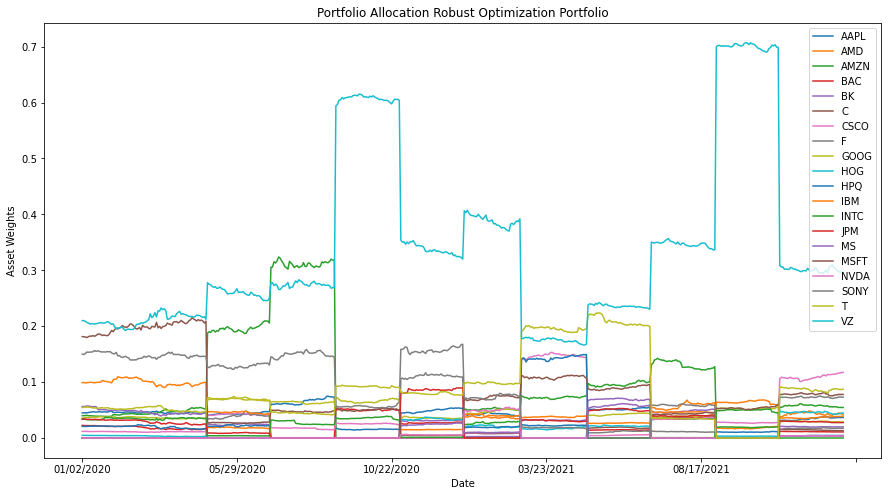

In [51]:
#ploting the chart showing Portfolio Allocation for Robust Strategy
da_valuedf7.plot.line(figsize = (15,8))
plt.title('Portfolio Allocation Robust Optimization Portfolio')
plt.xlabel('Date')
plt.ylabel('Asset Weights')

## 2008-2009

In [52]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio

init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 7  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

In [53]:
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
rob_bnd = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
Portf_Retn = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
borrow = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
startdate = []
enddate = []
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    
    startdate.append(day_ind_start)
    enddate.append(day_ind_end)
    

   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:] 

   # Execute portfolio selection strategies
    for strategy  in range(N_strat):

      # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            curr_borrow = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
            curr_borrow = borrow[strategy, period-2]

      # Compute strategy
        x[strategy, period-1], cash[strategy, period-1], borrow[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, curr_borrow)
       
      #Verify that strategy is feasible (you have enough budget to re-balance portfolio): See function rebalance
      #Check that cash account is >= 0: See function rebalance
      #Check that we can buy new portfolio subject to transaction costs: See function rebalance

        #print(' "{0}" Cash Account Balance = $ {1:.2f}'.format(strategy_names[strategy], cash[strategy, period-1]))  
      # Compute portfolio value

        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        begin_value = portf_value[strategy][day_ind_start][0]-borrow[strategy, period-1]
        value_end = portf_value[strategy][day_ind_end][0]-(borrow[strategy, period-1]*((1+0.025)**(1/6)))
        print('Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             begin_value, value_end))
        rob_bnd[strategy, period-1], Portf_Retn[strategy, period-1] = printtargets(mu, Q, curr_positions, cur_prices, period, strategy)
      
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Initial portfolio value = $ 385097.15


Period 1: start date 01/02/2008, end date 02/29/2008
Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
Strategy "Equally Weighted Portfolio", value begin = $ 383564.94, value end = $ 328629.14
Strategy "Mininum Variance Portfolio", value begin = $ 384887.86, value end = $ 328458.01
Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 383181.37, value end = $ 334322.21
Strategy "Equal Risk Contributions Portfolio", value begin = $ 383467.21, value end = $ 330810.63
Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 381786.07, value end = $ 274940.07
Strategy "Robust Optimization Portfolio", value begin = $ 383741.65, value end = $ 325985.02

Period 2: start date 03/03/2008, end date 04/30/2008
Strategy "Buy and Hold", value begin = $ 325807.08, value end = $ 349997.20
Strategy "Equally Weighted Portfolio", value begin = $ 324096.87, value end = $ 357027.26
Strategy "Mininum Variance Portfolio"

Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 155484.77, value end = $ 190467.16
Strategy "Robust Optimization Portfolio", value begin = $ 324293.93, value end = $ 362617.78


### Daily value each strategy

In [54]:
#daily value each strategy
Dates1, Buy_hold = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=0)
Dates1, Eq_weight = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=1)
Dates1, Min_var = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=2)
Dates1, Max_sharpe = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=3)
Dates1, Equal_risk_contr = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=4)
Dates1, Lever_equal_risk_contr = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=5)
Dates1, Robust_optim = daily_value(startdate, enddate, periods, cash, data_prices, dates, strategy=6)

In [55]:
#creating a dataframe contatining the daily portfolio value for each strategy 

da_valuedf = pd.DataFrame(index = Dates1) 
da_valuedf['Buy_hold'] = Buy_hold
da_valuedf['Eq_weight'] = Eq_weight
da_valuedf['Min_var'] = Min_var
da_valuedf['Max_sharpe'] = Max_sharpe
da_valuedf['Equal_risk_contr'] = Equal_risk_contr
da_valuedf['Lever_equal_risk_contr'] = Lever_equal_risk_contr
da_valuedf['Robust_optim'] = Robust_optim

Text(0, 0.5, 'Value $ (In Millions)')

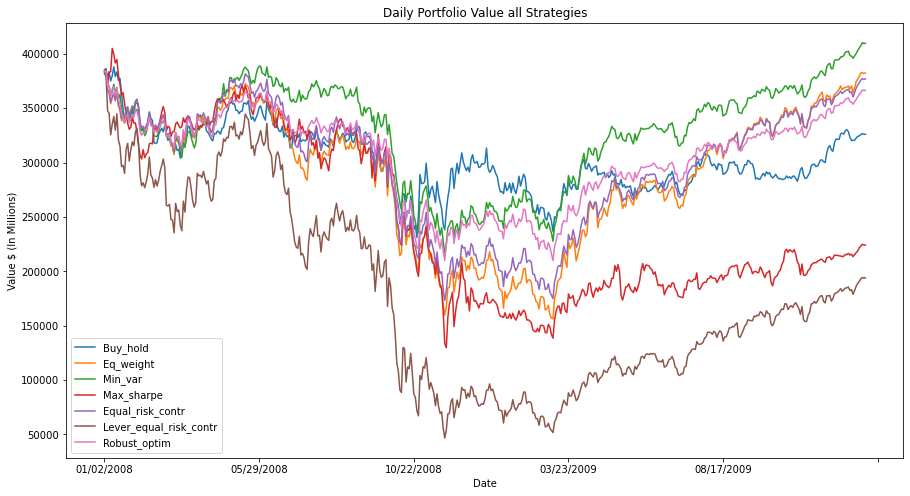

In [56]:
#Showing all strategies in one chart 
da_valuedf.plot.line(figsize = (15,8))
plt.title('Daily Portfolio Value all Strategies')
plt.xlabel('Date')
plt.ylabel('Value $ (In Millions)')

### Maximum Drawdown 2008-2009

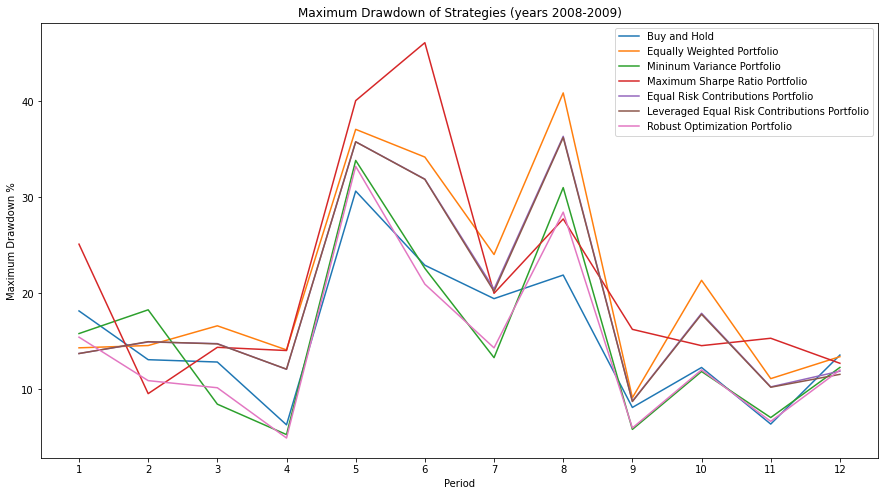

In [57]:
#maximum drawdown
fig = plt.figure(figsize=(15,8))
for strategy in range(N_strat):
    max_dd_list = []
    for period in range(1, N_periods+1):
        if dates_array[0, 0] == 8:
            cur_year  = 8 + math.floor(period/7)
        else:
            cur_year  = 2008 + math.floor(period/7)

        cur_month = 2*((period-1)%6) + 1
        day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
        day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
        maxdrawdown = abs(portf_value[strategy][day_ind_start:day_ind_end+1].max()-portf_value[strategy][day_ind_start:day_ind_end+1].min())/portf_value[strategy][day_ind_start:day_ind_end+1].max()*100
        max_dd_list.append(maxdrawdown)
    plt.plot(range(1,13),max_dd_list,label=strategy_names[strategy])
plt.xlabel('Period')
plt.ylabel('Maximum Drawdown %')
plt.title('Maximum Drawdown of Strategies (years 2008-2009)')
plt.xticks(np.arange(1,13))
plt.yticks()
plt.legend()
plt.show()

### Dynamic Change of weights

In [58]:
#calculating dynamic change in the weights for Min variance and Max Sharpe ratio strategies
Dates1, Min_var_weights = dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=2)
Dates1, Max_sharpe_weight = dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=3)
Dates1, Robust_optim_weight = dynamic_change(startdate, enddate, periods, cash, data_prices, dates, strategy=6)

In [59]:
da_valuedf3 = pd.DataFrame(Min_var_weights, columns = list(df.columns)[1:], index = Dates1)
da_valuedf4 = pd.DataFrame(Max_sharpe_weight, columns = list(df.columns)[1:], index = Dates1)
da_valuedf7 = pd.DataFrame(Robust_optim_weight, columns = list(df.columns)[1:], index = Dates1)

Text(0, 0.5, 'Asset Weights')

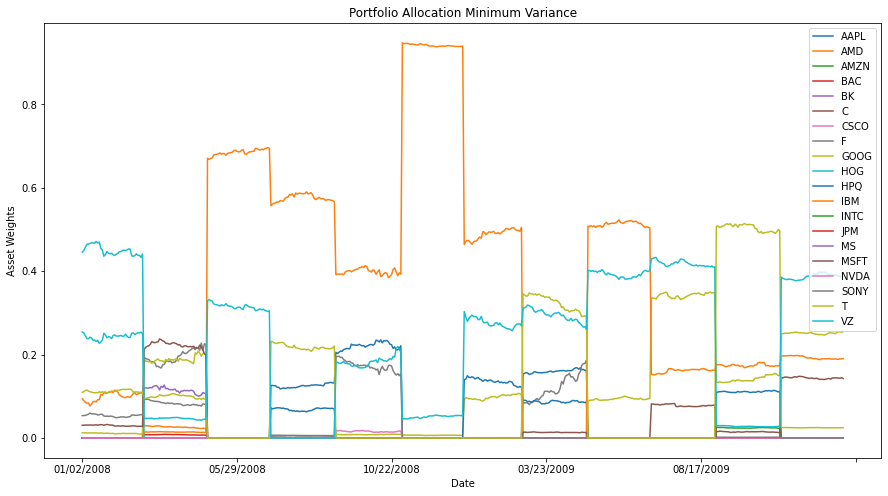

In [60]:
#ploting the chart showing Portfolio Allocation for Minimum variance Strategy
da_valuedf3.plot.line(figsize = (15,8))
plt.title('Portfolio Allocation Minimum Variance')
plt.xlabel('Date')
plt.ylabel('Asset Weights')

Text(0, 0.5, 'Asset Weights')

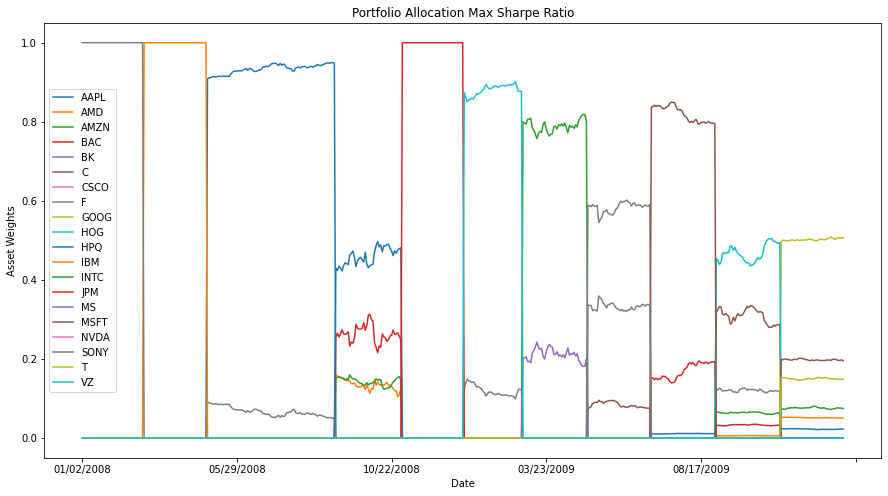

In [61]:
#ploting the chart showing Portfolio Allocation for Max Sharpe Ratio Strategy
da_valuedf4.plot.line(figsize = (15,8))
plt.title('Portfolio Allocation Max Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Asset Weights')

Text(0, 0.5, 'Asset Weights')

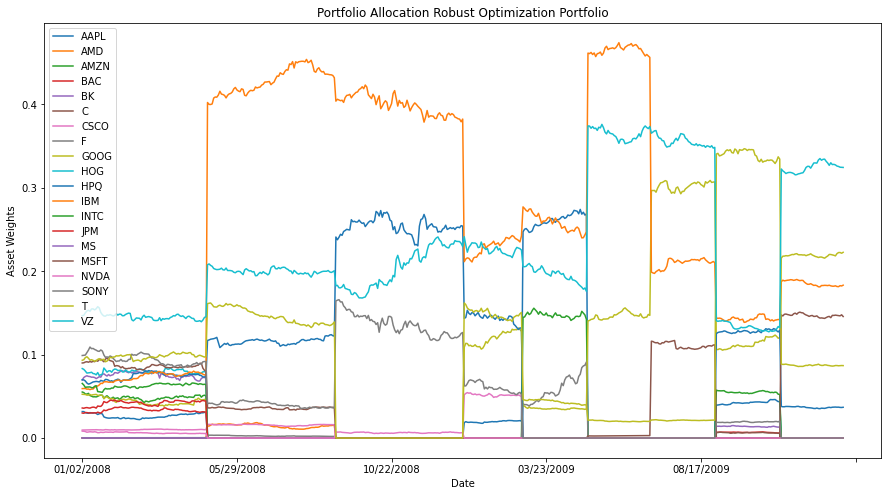

In [62]:
#ploting the chart showing Portfolio Allocation for Robust Strategy
da_valuedf7.plot.line(figsize = (15,8))
plt.title('Portfolio Allocation Robust Optimization Portfolio')
plt.xlabel('Date')
plt.ylabel('Asset Weights')